In [8]:
import tensorflow as tf
import chess
import chess.svg
import numpy as np
import chess.pgn
import time
import asyncio
import chess.engine
import datetime
import keras
import random
import matplotlib.pyplot as plt
from chess.engine import Cp, Mate, MateGiven
from IPython.display import SVG
from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from numpy import array

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
engine = chess.engine.SimpleEngine.popen_uci("C:/Users/Conor/Downloads/stockfish.exe")
X_size = np.zeros((1,8,8),dtype = int)
X_train= np.array([], dtype=np.float64)
Y_train= np.array([], dtype=np.float64)
model = Sequential()
model.add(LSTM(output_dim=1024,input_shape = X_size.shape[1:],return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Dense(output_dim=1,activation = 'selu'))

model.compile(loss="mse", optimizer="rmsprop")


Num GPUs Available:  1


c:\users\conor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(8, 8), return_sequences=True, units=1024)`
c:\users\conor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="selu", units=1)`


In [3]:
def processScore(estScore):
    estScore = str(estScore)
    if ('#' in estScore):
        estScore = estScore.replace('#','')
        estScore = int(estScore)
        if(estScore > 0):
            estScore = int((10-estScore)*1000)
        else:
            estScore = int((-10-estScore)*1000)
    estScore = int(estScore)
    return estScore

def getScore():
    info = engine.analyse(board, chess.engine.Limit(time=0.1))
    if board.turn: #white
        score = -(int(processScore(info.get("score"))))
    else:
        score = (int(processScore(info.get("score"))))
    if (score > 1000):
        score = score / 3
    return score
    
    
def convertBoard():
    l = np.zeros(64)
    for sq in chess.scan_reversed(board.occupied_co[chess.WHITE]):
        l[sq] = board.piece_type_at(sq)
    for sq in chess.scan_reversed(board.occupied_co[chess.BLACK]):
        l[sq] = -board.piece_type_at(sq)
    l = l.reshape((8,8))
    l = np.flip(l,0)
    return l

def initTrainSet():
    global X_train
    global Y_train
    X_train= np.array([], dtype=np.float64)
    Y_train= np.array([], dtype=np.float64)
    
def addTrainSet():
    global X_train
    global Y_train
    tmp = convertBoard()
    tmp = array(tmp)
    tmp = tmp.reshape((1,tmp.shape[0],tmp.shape[1]))
    X_train = np.append(X_train,tmp)
    Y_train = np.append(Y_train,array(getScore()))
    
def resizeDataSet():
    global X_train
    global Y_train
    X_train = X_train.reshape((Y_train.shape[0],8,8))

def deepEval():
    x= np.array([], dtype=np.float64)
    tmp = convertBoard()
    tmp = array(tmp)
    tmp = tmp.reshape((1,tmp.shape[0],tmp.shape[1]))
    return (model.predict(tmp))

def attemptTraining():
    global X_train
    global Y_train
    tf.keras.utils.normalize(
    Y_train, axis=0, order=2)
    print('normalising')
    print(Y_train)
    history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=64,shuffle=True)
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
def quiesce2( alpha, beta ):
    stand_pat = deepEval()
    if( stand_pat >= beta ):
        return beta
    if( alpha < stand_pat ):
        alpha = stand_pat
    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiesce2( -beta, -alpha )
            board.pop()
            if( score >= beta ):
                return beta
            if( score > alpha ):
                alpha = score  
    return alpha

def alphabeta2( alpha, beta, depthleft ):
    bestscore = -9999
    if( depthleft == 0 ):
        return quiesce2( alpha, beta )
    for move in board.legal_moves:
        board.push(move)
        score = -alphabeta2( -beta, -alpha, depthleft - 1 )
        board.pop()
        if( score >= beta ):
            return score
        if( score > bestscore ):
            bestscore = score
        if( score > alpha ):
            alpha = score   
    return bestscore

def selectmove2():
    bestMove = chess.Move.null()
    bestValue = -99999
    alpha = -100000
    beta = 100000
    for move in board.legal_moves:
        board.push(move)
        boardValue = -alphabeta2(-beta, -alpha, 1)
        if boardValue > bestValue:
            bestValue = boardValue;
            bestMove = move
        if( boardValue > alpha ):
            alpha = boardValue
        board.pop()
    return bestMove

In [5]:
def quiesce( alpha, beta ):
    stand_pat = deepEval()
    if( stand_pat >= beta ):
        return beta
    if( alpha < stand_pat ):
        alpha = stand_pat
    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiesce( -beta, -alpha )
            addTrainSet()
            board.pop()
            if( score >= beta ):
                return beta
            if( score > alpha ):
                alpha = score  
    return alpha

def alphabeta( alpha, beta, depthleft ):
    bestscore = -9999
    if( depthleft == 0 ):
        return quiesce( alpha, beta )
    for move in board.legal_moves:
        board.push(move)
        score = -alphabeta( -beta, -alpha, depthleft - 1 )
        addTrainSet()
        board.pop()
        if( score >= beta ):
            return score
        if( score > bestscore ):
            bestscore = score
        if( score > alpha ):
            alpha = score   
    return bestscore

def selectmove():
    bestMove = chess.Move.null()
    bestValue = -99999
    alpha = -100000
    beta = 100000
    for move in board.legal_moves:
        board.push(move)
        addTrainSet()
        boardValue = -alphabeta(-beta, -alpha, 1)
        if boardValue > bestValue:
            bestValue = boardValue;
            bestMove = move
        if( boardValue > alpha ):
            alpha = boardValue
        board.pop()
    return bestMove  

In [6]:
def randomMove():
    randomMove = []
    for move in board.legal_moves:
        randomMove.append(move)
    randVal = random.randint(0,(len(randomMove)-1))
    board.push(randomMove[randVal])
    
def playMove():
    mov = selectmove2()
    board.push(mov)
    

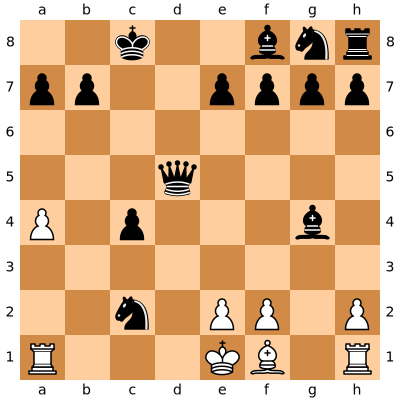

In [10]:
board = chess.Board()
initTrainSet()
while not board.is_game_over():
    if board.turn: #white
        randomMove()
    else: #Black
        result = engine.play(board, chess.engine.Limit(time=0.1))
        board.push(result.move)
    clear_output()
    display(SVG(chess.svg.board(board=board,size=400))) 
    addTrainSet()
    time.sleep(3)
resizeDataSet()

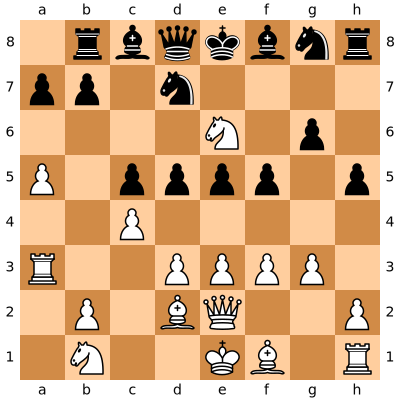

Game Over


In [11]:
board = chess.Board()
print(board)
ii = 0
while not board.is_game_over() and ii <= 40:
    if board.turn: #white
        randomMove()
    else: #Black
        playMove()
    clear_output()
    display(SVG(chess.svg.board(board=board,size=400))) 
    time.sleep(0.5)
    ii +=1
print('Game Over')

31


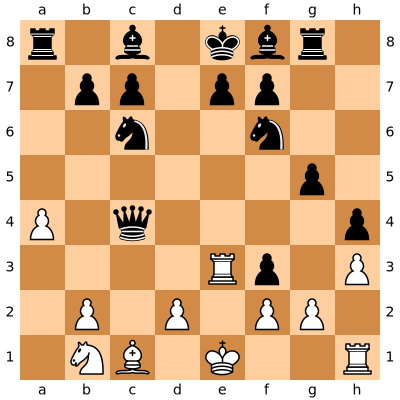

Game complete
normalising
[-125.           50.          -74.         ...  860.66666667 1004.66666667
 1021.66666667]
Epoch 1/64
7053/7053 [==============================] - 10s 1ms/step - loss: 401541.4819
Epoch 2/64
7053/7053 [==============================] - 9s 1ms/step - loss: 396347.7211
Epoch 3/64
7053/7053 [==============================] - 9s 1ms/step - loss: 370085.3751
Epoch 4/64
7053/7053 [==============================] - 9s 1ms/step - loss: 362942.6591
Epoch 5/64
7053/7053 [==============================] - 9s 1ms/step - loss: 367382.5077
Epoch 6/64
7053/7053 [==============================] - 9s 1ms/step - loss: 354034.0441
Epoch 7/64
7053/7053 [==============================] - 9s 1ms/step - loss: 351049.4207
Epoch 8/64
7053/7053 [==============================] - 9s 1ms/step - loss: 336256.0824
Epoch 9/64
7053/7053 [==============================] - 9s 1ms/step - loss: 328253.1407
Epoch 10/64
7053/7053 [==============================] - 9s 1ms/step - loss: 324852.7779
E

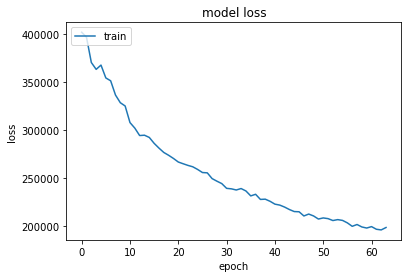

Training Over


In [9]:
initTrainSet()
clear_output()
for i in range(0,3):
    board = chess.Board()
    ii = 0
    while not board.is_game_over() and ii <= 30:
        if board.turn: #white
            randomMove()
        else: #Black
            mov = selectmove()
            board.push(mov)
        ii += 1
        clear_output()
        print(ii)
        display(SVG(chess.svg.board(board=board,size=400))) 
    print('Game complete')
    resizeDataSet()
    attemptTraining()
    initTrainSet()
print('Training Over')

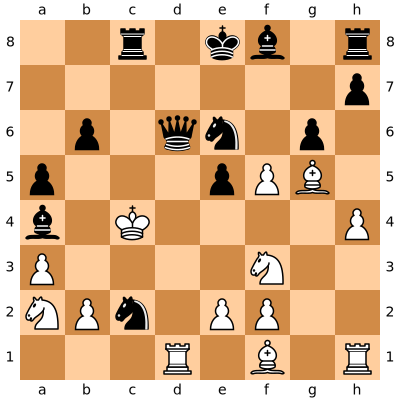

In [13]:
board = chess.Board()
result = engine.play(board, chess.engine.Limit(time=0.1))
board.push(result.move)
print(board)
initTrainSet()
while not board.is_game_over():
    if board.turn: #white
        randomMove()
    else: #Black
        playMove()
    clear_output()
    display(SVG(chess.svg.board(board=board,size=400))) 
    time.sleep(0.5)
resizeDataSet()

Play against random agent 
Also Play against stockfish